## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

## import the required libraries

In [1]:

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

from os import listdir
from os.path import isfile, join
import collections

%matplotlib qt

# Define global values
ret, mtx, dist, rvecs, tvecs = None, None, None, None, None
vehical_offset = 0

### Loading the distortion coefficients
coeff = pickle.load(open("wide_dist_pickle.p","rb"))
mtx = coeff['mtx']
dist = coeff['dist']

Wrote the image: calibration17.jpg
Wrote the image: calibration7.jpg
Wrote the image: calibration10.jpg
Wrote the image: calibration1.jpg
Wrote the image: calibration19.jpg
Wrote the image: calibration4.jpg
Wrote the image: calibration16.jpg
Wrote the image: calibration20.jpg
Wrote the image: calibration13.jpg
Wrote the image: calibration6.jpg
Wrote the image: calibration11.jpg
Wrote the image: calibration9.jpg
Wrote the image: calibration18.jpg
Wrote the image: calibration2.jpg
Wrote the image: calibration12.jpg
Wrote the image: calibration8.jpg
Wrote the image: calibration15.jpg
Wrote the image: calibration5.jpg
Wrote the image: calibration14.jpg
Wrote the image: calibration3.jpg


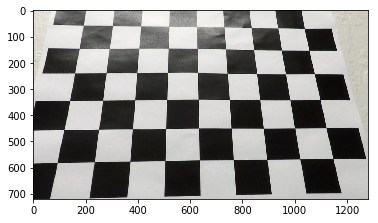

In [2]:
only_once_camera_calibrate = True

def computeCalibrationAndUndistort(img_input_dir, img_output_dir):
       
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(img_input_dir + 'calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    images = [f for f in listdir(img_input_dir) if isfile(join(img_input_dir, f))]
    # call undistort
    for fname in images:
        img = mpimg.imread(img_input_dir + fname)
        # product the undistort image
        dst = cal_undistort(img, objpoints, imgpoints)
        # plt.figure()
        plt.imshow(dst)
        cv2.imwrite(img_output_dir + fname, dst)
        print("Wrote the image: " + fname)
            
def cal_undistort(img, objpoints, imgpoints):
    global ret, mtx, dist, rvecs, tvecs
    
    if only_once_camera_calibrate:
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
        
if __name__ == '__main__':
    # undistort the camera_cal directory images and put them iinto output_images
    computeCalibrationAndUndistort(img_input_dir = "camera_cal/", img_output_dir = "output_images/")
    
#cv2.destroyAllWindows()

## Distortion Correction

In [9]:
# undistort the test_images directory images and put them into test_images_output

images = [f for f in listdir("test_images/") if isfile(join("test_images/", f))]

for fname in images:
        img = mpimg.imread("test_images/" + fname)
        undist = cv2.undistort(img,mtx,dist,None,mtx)
        cv2.imwrite("test_images_output/distortion-corrected/" + fname, undist)
        

## Image Thresholding

In [2]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(hls, index, thresh=(0, 255)):
    # hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,index]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

#hls_binary = hls_select(image, thresh=(90, 255))

def combine_binary(undist):
    ksize = 5
            
    gradx = abs_sobel_thresh(undist, orient='x', thresh_min=5, thresh_max=100)
    grady = abs_sobel_thresh(undist, orient='y', thresh_min=30, thresh_max=100)
  
    mag_binary = mag_thresh(undist, sobel_kernel=9, mag_thresh=(20, 100))
    #dir_binary = dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2))
    dir_binary = dir_threshold(undist, sobel_kernel=21, thresh=(-1.3,1.3))
    hls = cv2.cvtColor(undist,cv2.COLOR_RGB2HLS)
    H_th = hls_select(hls,0,(5,50))
    S_th = hls_select(hls,2,(100,255))
    L_th = hls_select(hls,1,(0,101))
    combined = np.zeros_like(dir_binary)
    combined[ ((gradx == 1)  & (grady==1)) |( (mag_binary == 1) &(dir_binary==1)) | ((H_th==1)&(S_th==1) )] = 1
    combined=combined-L_th
    combined_binary = np.zeros_like(combined)
    combined_binary[combined>0]=1
    return combined_binary
    

In [4]:
images = [f for f in listdir("test_images/") if isfile(join("test_images/", f))]

for fname in images:
        img = mpimg.imread("test_images/" + fname)
        undist = cv2.undistort(img,mtx,dist,None,mtx)
        
        threshold_img = combine_binary(undist)
        print("Writing threshold image:"+fname)
        cv2.imwrite("test_images_output/img_threshold/" + fname, threshold_img*255)

Writing threshold image:test4.jpg
Writing threshold image:straight_lines1.jpg
Writing threshold image:test5.jpg
Writing threshold image:test1.jpg
Writing threshold image:test3.jpg
Writing threshold image:test2.jpg
Writing threshold image:straight_lines2.jpg
Writing threshold image:test6.jpg


## Perspective Transformation

In [3]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(threshold_image):
    shape = threshold_image.shape
    
    offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (shape[1], shape[0])

    # For source points I'm putting the outer four detected corners
    src = np.float32([[560, 470],[720, 470],[1120, 725],[210,725]])
    #src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    #dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
    #                             [img_size[0]-offset, img_size[1]-offset], 
    #                             [offset, img_size[1]-offset]])
    dst = np.float32([[310,0],[910,0],[910,720],[310,720]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src) # inverse transformation to get image again
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(threshold_image, M, img_size, flags=cv2.INTER_LINEAR)
    # Return the resulting image and matrix
    return warped, M, Minv



In [27]:

images = [f for f in listdir("test_images/") if isfile(join("test_images/", f))]

for fname in images:
    img = mpimg.imread("test_images/" + fname)
    # img = cv2.imread('test_image2.png')
    nx = 8 # the number of inside corners in x
    ny = 6 # the number of inside corners in y

    undist = cv2.undistort(img,mtx,dist,None,mtx)
    
    top_down, perspective_M, Minv = corners_unwarp(undist)
    
    print("Writing birds-eye-view image:"+fname)
    cv2.imwrite("test_images_output/birds-eye-view/" + fname, top_down)


Writing birds-eye-view image:test4.jpg
Writing birds-eye-view image:straight_lines1.jpg
Writing birds-eye-view image:test5.jpg
Writing birds-eye-view image:test1.jpg
Writing birds-eye-view image:test3.jpg
Writing birds-eye-view image:test2.jpg
Writing birds-eye-view image:straight_lines2.jpg
Writing birds-eye-view image:test6.jpg


## Finding the Lines: Sliding Window

In [11]:
def find_lane_pixels(binary_warped, draw_window = True):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        if draw_window == True:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2)
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, draw_window = True):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, draw_window)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    # plt.plot(left_fitx, ploty, color='yellow')
    # plt.plot(right_fitx, ploty, color='yellow')

    return out_img





In [12]:
# Load our images
images = [f for f in listdir("test_images/") if isfile(join("test_images/", f))]

for fname in images:
    # Load an Image
    img = mpimg.imread("test_images/" + fname)
    # Undistort it
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    # create threshold image using undistort image
    threshold_img = combine_binary(undist)
    # Apply perspective transformation
    binary_warped, perspective_M, Minv = corners_unwarp(threshold_img)
    

    out_img = fit_polynomial(binary_warped)

    # plt.imshow(out_img)
    
    print("Writing sliding window image:"+fname)
    cv2.imwrite("test_images_output/identified-lane-line/" + fname, out_img)
    

Writing sliding window image:test4.jpg
Writing sliding window image:straight_lines1.jpg
Writing sliding window image:test5.jpg
Writing sliding window image:test1.jpg
Writing sliding window image:test3.jpg
Writing sliding window image:test2.jpg
Writing sliding window image:straight_lines2.jpg
Writing sliding window image:test6.jpg


## Computing offset value

In [13]:
def compute_offset(left_fit_x, right_fit_x, img_size):
    lane_center = (left_fit_x[-1] + right_fit_x[-1]) / 2
    xm_per_pix = 3.7/700
    return abs(img_size[1]/2 - lane_center) * xm_per_pix

##  Final Pipeline

In [28]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = np.array([0,0,0], dtype='float')   
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

    # update stored detection state of the lanes.
    def update_detection(self,detected_x,detected_y,x_px_values,fit_coef,img_shape):
        if len(self.recent_xfitted) == 20:
            self.recent_xfitted.pop(0)
        self.recent_xfitted.append(x_px_values)
        self.bestx = np.mean(self.recent_xfitted,axis=0)
        self.best_fit = (self.best_fit+fit_coef)/2
        self.diffs = self.current_fit - fit_coef
        self.current_fit = fit_coef
        self.allx = detected_x
        self.ally = detected_y
        self.radius_of_curvature = compute_curvature(img_shape,detected_x,detected_y)
    
    def get_bestx(self):
        return self.bestx
    
    def is_prev_frame(self):
        return self.detected
    
    def set_prev_frame_flag(self,flag):
        self.detected=flag
    
    


# Method for fitting the polynomial
def fit_poly(lane_x,lane_y,ploty):
    lane_fit = np.polyfit(lane_y,lane_x,2)
    lane_fitx = lane_fit[0]*ploty**2+lane_fit[1]*ploty+lane_fit[2]
    return lane_fit,lane_fitx

# Method for search the pixels around the poly
def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) +
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) +
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

def draw_around_poly(binary_warped, Minv, img, ploty):  
    # Create an image to draw the lines
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # build the x and y points for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_lane.get_bestx(), ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_lane.get_bestx(), ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(warp, np.int_([pts]), (0,255, 0))

    # Create the new warped image back using inv. perspective
    return cv2.warpPerspective(warp, Minv, (img.shape[1], img.shape[0])) 

# Compute the slope
def compute_slope(fit,y_value):
    return 2*y_value*fit[0]+fit[1]

# computing the curvature
def compute_curvature(img_shape,detected_x,detected_y):
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    fit = np.polyfit(detected_y*ym_per_pix, detected_x*xm_per_pix, 2)
    y_eval = np.max(detected_y)
    curverad = ((1 + (2*fit[0]*y_eval*ym_per_pix + fit[1])**2)**1.5) / np.absolute(2*fit[0])
    return curverad
    
def detecting_lane_lines(img):
    global vehical_offset
    # Undistort the imundist = cv2.undistort(image,mtx,dist,None,mtx)age
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    # Threshold the image
    threshold_img = combine_binary(undist)
    # Apply perspective transformation
    binary_warped, perspective_M, Minv = corners_unwarp(threshold_img)
    ploty = np.linspace(0,binary_warped.shape[0]-1,binary_warped.shape[0]) 
    
     # check if lane was detected in last frame
    if (left_lane.is_prev_frame()) & (right_lane.is_prev_frame()):
        ## targeted search around polynomial
        leftx, lefty, rightx, righty = search_around_poly(binary_warped,left_lane.best_fit,right_lane.best_fit)
        
        if (len(leftx) != 0 ) & (len(rightx)!=0): ## if any pixels are detected
            left_fit,left_fitx = fit_poly(leftx,lefty,ploty)
            right_fit,right_fitx = fit_poly(rightx,righty,ploty)
            ## calculate difference in curvatures and slopes
            curvature_diff  = abs(compute_curvature(binary_warped.shape,leftx,lefty) - compute_curvature(binary_warped.shape,rightx,righty))
            slope_diff = abs(compute_slope(left_fit,np.mean(lefty)) - compute_slope(right_fit,np.mean(righty)))
            # check if diff is unrealistic
            if (curvature_diff < 2) & (slope_diff < 0.3):
                left_lane.update_detection(leftx,lefty,left_fitx,left_fit,binary_warped.shape)
                right_lane.update_detection(rightx,righty,right_fitx,right_fit,binary_warped.shape)
            else:
                left_lane.set_prev_frame_flag(False)
                right_lane.set_prev_frame_flag(False)
        else:
            left_lane.set_prev_frame_flag(False)
            right_lane.set_prev_frame_flag(False)
    else: ## if no line detected in last frame, need to detect again from scratch
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, False)
        ## Update if any pixels are detected
        if len(leftx) != 0: 
            left_fit,left_fitx = fit_poly(leftx,lefty,ploty)
            left_lane.update_detection(leftx,lefty,left_fitx,left_fit,binary_warped.shape)
            left_lane.set_prev_frame_flag(True)
        
        if len(rightx) != 0:
            right_fit,right_fitx = fit_poly(rightx,righty,ploty)
            right_lane.update_detection(rightx,righty,right_fitx,right_fit,binary_warped.shape)
            right_lane.set_prev_frame_flag(True)
        #Compute vehicle offset from center id lane pixels are detected    
        if (len(leftx) != 0 ) & (len(rightx)!=0):
            vehical_offset = compute_offset(left_fitx,right_fitx,binary_warped.shape)

    new_warp = draw_around_poly(binary_warped, Minv, img, ploty)
    # Combine the newwarp with the original image
    combined_img = cv2.addWeighted(undist, 1, new_warp, 0.3, 0)
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (100,100)
    fontScale              = 1
    fontColor              = (255,0,0)
    lineType               = 2
    lcurve = "Left radius of curvature in km: " + str(left_lane.radius_of_curvature/1000)
    rcurve = "Right radius of curvature in km: " + str(right_lane.radius_of_curvature/1000)
    offset = "Vehicle offset in m: "+str(vehical_offset)
    
    cv2.putText(combined_img,lcurve, bottomLeftCornerOfText, font, fontScale,fontColor,lineType)
    bottomLeftCornerOfText = (100,150)
    cv2.putText(combined_img,rcurve, bottomLeftCornerOfText, font, fontScale,fontColor,lineType)
    bottomLeftCornerOfText = (100,200)
    cv2.putText(combined_img,offset, bottomLeftCornerOfText, font, fontScale,fontColor,lineType)
    
    return combined_img
    
    
    
    
    
    
    
    

Writing final image:test4.jpg
Writing final image:straight_lines1.jpg
Writing final image:test5.jpg
Writing final image:test1.jpg
Writing final image:test3.jpg
Writing final image:test2.jpg
Writing final image:straight_lines2.jpg
Writing final image:test6.jpg


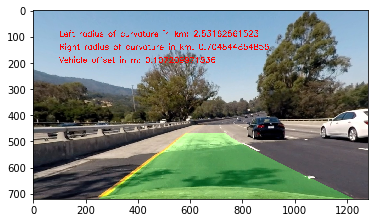

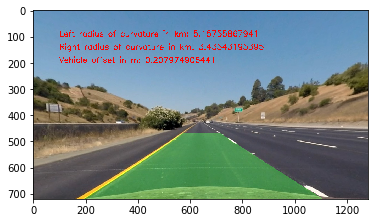

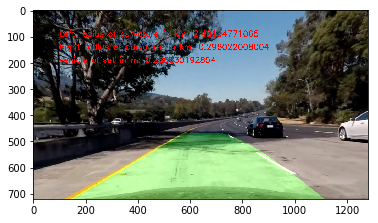

In [ ]:
images = [f for f in listdir("test_images/") if isfile(join("test_images/", f))]

for fname in images:
    # intantiate the line configure class
    left_lane = Line()
    right_lane = Line()
    
    # Load an Image
    img = mpimg.imread("test_images/" + fname)
    
    final_img = detecting_lane_lines(img)
    plt.figure()
    plt.imshow(final_img)
    print("Writing final image:"+fname)
    cv2.imwrite("test_images_output/lane-boundaries/" + fname, final_img)